## Multi-armed bandits (3 pts.)
In this part of the homework, you will reproduce some of the results in Chapter 2 of the Sutton and Barto
book.
Suppose that you have a 10-armed bandit problem—i.e., an agent has to select among a set of 10
different actions, each of which yields a different (average) reward. In particular, suppose that the actual
reward associated with each action a ∈ {1, . . . , 10} is a random variable following a Gaussian distribution
with mean Q(a) and variance 1.
You will compare the average reward received by:
* A greedy policy, where the estimated reward for each action a is initialized as Qˆ(a) = 0;
* A greedy policy, where the estimated reward for each action a is initialized as Qˆ(a) = 5;
* An ε-greedy policy, with ε = 0.1, where the estimated reward for each action a is initialized as Qˆ(a) = 0;
* An ε-greedy policy, with ε = 0.01, where the estimated reward for each action a is initialized as
Qˆ(a) = 0;
* The UCB policy.

To do this,
1. Select the average values Q(a), a ∈ {1, . . . , 10} , at random from a normal distribution with mean 0
and variance 1;
2. Run the policies listed above for 1, 000 steps and compute, for each policy, the reward received at each
time step;
3. Repeat the two previous steps 2, 000 times;
4. Compute the reward obtained at each time step by each of the policies averaged across the 2, 000 trials.

### Question 1.
Using the results from the procedure outlined above, plot the average reward obtained
with each policy during the 1, 000 steps in a single plot. Comment the differences observed.m

#### Initializing tuples

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [38]:
argmax = np.argmax(q_hat5[:, i])

In [2]:
class Bandit:
    def __init__(self, arm_num, epsilon, c, initial=0):
        self.k = arm_num
        self.epsilon = epsilon
        self.c = c  #
        self.initial = initial
        self.reset()

    def reset(self):
        self.q_hat = np.zeros(self.k) + self.initial
        self.n = np.zeros(self.k)  # number of times each action is taken
        self.t = 0
        self.q = np.random.normal(0, 1, self.k)

    def act(self):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.k)
        else:
            return np.argmax(self.q_hat)

    def step(self, a):
        r = np.random.normal(self.q[a], 1)
        self.t += 1
        self.n[a] += 1
        self.q_hat[a] = self.q_hat[a] + (r - self.q_hat[a]) / (self.n[a])
        return r

    def simulate(bandit, time_steps):
        bandit.reset()
        rewards = np.zeros(time_steps)
        actions = np.zeros(time_steps)
        for i in range(time_steps):
            a = bandit.act()
            r = bandit.step(a)
            rewards[i] = r
            actions[i] = a
        return rewards, actions

    def simulate_multiple(bandit, time_steps, n):
        rewards = np.zeros((n, time_steps))
        actions = np.zeros((n, time_steps))
        for i in range(n):
            r, a = bandit.simulate(time_steps)
            rewards[i] = r
            actions[i] = a
        return rewards, actions


class UCBBandit(Bandit):
    def act(self):
        ucb_vals = np.zeros(self.k)
        for i in range(self.k):
            ucb_vals[i] = self.q_hat[i] + self.c * np.sqrt(
                np.log(self.t) / self.n[i]
            )
        return np.argmax(ucb_vals)

    def step(self, a):
        r = np.random.normal(self.q[a], 1)
        self.t += 1
        self.n[a] += 1
        # update the average
        self.q_hat[a] = self.q_hat[a] + (r - self.q_hat[a]) / (self.n[a])
        return r

In [3]:
b0 = Bandit(10, 0, 1, 0)
b5 = Bandit(10, 0, 1, 5)
be1 = Bandit(10, 0.1, 1, 0)
be01 = Bandit(10, 0.01, 1, 0)
bucb = UCBBandit(10, 1, 1, 0)

In [ ]:
rw0, ac0 = b0.simulate_multiple(1000, 2000)
rw5,ac5 = b5.simulate_multiple(1000, 2000)
rwe1 ,ace1 = be1.simulate_multiple(1000, 2000)
rwe01, ace01 = be01.simulate_multiple(1000, 2000)
rwucb,acucb = bucb.simulate_multiple(1000, 2000)


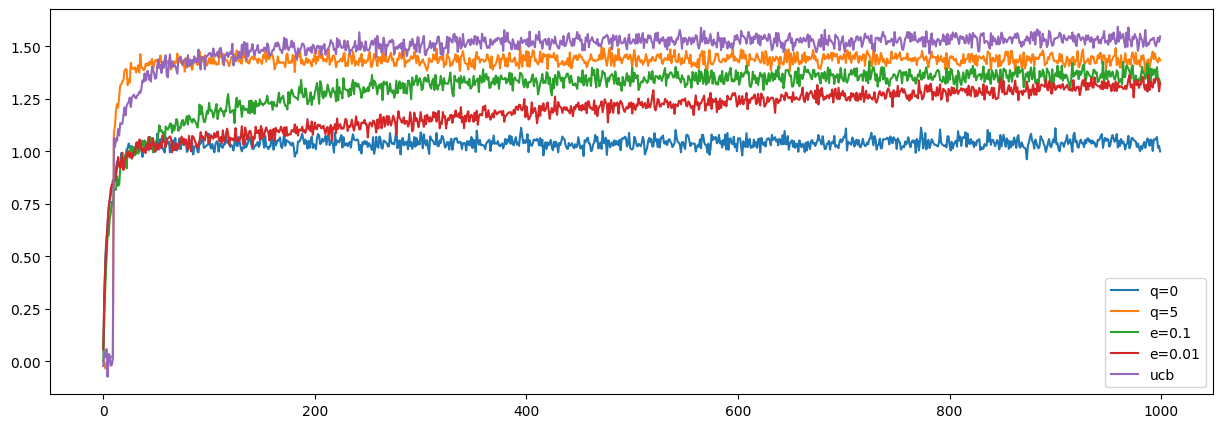

In [45]:
plt.figure(figsize=(15, 5))
plt.plot(rw0.mean(axis=0), label="q=0")
plt.plot(rw5.mean(axis=0), label="q=5")
plt.plot(rwe1.mean(axis=0), label="e=0.1")
plt.plot(rwe01.mean(axis=0), label="e=0.01")
plt.plot(rwucb.mean(axis=0), label="ucb")
plt.legend()

## Answer

With the initialized greedy approach it quickly finds a good bandit, but it ceases exploring, meaning its average reward won't improve more, while UCB takes a but more iterations to find the optimal value but it then exploits it obtaining the highest value of all. Using an epsilon greedy it shows that it managed to find the optimal bandit faster given that by using a bigger epsilon, while the smaller epsilon seems like the it would further improve if it had more iterations to explore. Finally the regular greedy approach stagnated quickly and didn't improve any more, both greedy methods contain a very similar "signature", but the Q5 obtained a good approach more quickly, meaning this problem should perform better if there are few iterations. While the UCB sounds better overall, epsilon greedy might

# Q.2 The Gambler Problem

Consider the following problem, introduced in Chapter 4 of the Sutton and Barto book.
A gambler is engaged in a betting game, where he must place bets on the outcomes of a sequence of coin
flips. Before each flip, the gambler decides how much to bet on the outcome that the coin will come up
heads—note that he can only decide how much to bet, not in which outcome to bet.
If the coin does come up heads, the gambler doubles the money bet on that coin flip—in other words,
if the gambler bets $5 dollars, he will get his $5 dollars back plus another $5 dollars. If the coin comes up
tails, the gambler loses the money he bet. The game goes on until either the gambler reaches his goal of
$100 dollars, or loses by running out of money. On each flip, the gambler must decide what portion of his
capital to stake, in integer numbers of dollars. Suppose that the probability of the coin coming up heads is
pH = 0.4.
You will analyze the optimal betting policy for the gambler. To do so, model the gambler’s decision
problem as an MDP, specifying the state and action spaces, the transition probabilities and the reward
function. Make sure to use a reward function that only rewards the gambler for reaching his goal. Use a
discount γ = 1

Q2. Using the MDP model for the gambler problem, run value iteration. Plot, in the
same plot, the computed estimate for the optimal value function at iterations 1, 2, 3 and final (stop your
algorithm when the overall error is smaller than 10^−8). Can you provide an interpretation for the values
obtained? Plot also the optimal policy computed.
Note: The gambler problem is somewhat numerically unstable, so to compute the optimal policy make
sure to rounded up all values to 4 decimal places.

## Problem formulation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [107]:
# The states should be the money the gambler has {0,...,100}
goal = 100
states = np.arange(goal+1)
# The actions should be the money the gambler bets {0,..., min(s,100-s)}
actions = np.arange(goal)

# The transition table is as follows:
# 0.4 for heads
# 0.6 for tails
# The reward is 1 if the gambler wins and 0 otherwise
probability_matrix = np.zeros((len(actions), len(states), len(states)))
# when it reaches 0 it loses  or 100 wins (meaning it can't move anymore)

for i in range(len(states) - 1):
    for j in range(1, len(actions)):
        if i + j >= len(states):
            continue
        if i >= j:
            probability_matrix[j, i, min(j + i, len(states) - 1)] = 0.4
            probability_matrix[j, i, i - j] = 0.6
probability_matrix[:, 0, :] = 0
probability_matrix[:, max(states), :] = 0

reward_matrix = np.zeros((len(actions), len(states)))
reward_matrix[:, len(states) - 1] = 1

## Using Value iteration to obtain an optimal value function

In [216]:
big_v = np.zeros(len(states))
big_v[-1] = 0

delta = 0

thetha = 10e-8

gamma = 1

history = []

iter = 0
history.append(big_v.copy())

while True:
    delta = 0

    for s in states[1:-1]:
        old_v = big_v[s]

        big_v[s] = np.max(
            [
                np.sum([

                    probability_matrix[a, s, s_prime]
                    * (reward_matrix[a, s_prime] + gamma * big_v[s_prime])

                    for s_prime in [s - a, min(s + a, 100)]

                ])
                for a in range(0, min(s, goal - s)+1)
            ]
        )

        delta = max(delta, abs(old_v - big_v[s]))

    history.append(big_v.copy())

    iter += 1

    print(f"Iteraction {iter} | Delta {delta} | Theta {thetha}")
    if float(delta) < float(thetha):
        break

Iteraction 1 | Delta 0.9533440000000001 | Theta 1e-07
Iteraction 2 | Delta 0.3688960000000001 | Theta 1e-07
Iteraction 3 | Delta 0.13926400000000005 | Theta 1e-07
Iteraction 4 | Delta 0.05570560000000002 | Theta 1e-07
Iteraction 5 | Delta 0.02228224000000001 | Theta 1e-07
Iteraction 6 | Delta 0.008912896000000003 | Theta 1e-07
Iteraction 7 | Delta 0.0016384000000000008 | Theta 1e-07
Iteraction 8 | Delta 0.0003932160000000005 | Theta 1e-07
Iteraction 9 | Delta 7.602595430399994e-05 | Theta 1e-07
Iteraction 10 | Delta 3.041038172160032e-05 | Theta 1e-07
Iteraction 11 | Delta 2.6418075402233343e-06 | Theta 1e-07
Iteraction 12 | Delta 9.045549017728909e-07 | Theta 1e-07
Iteraction 13 | Delta 7.815354352569415e-08 | Theta 1e-07


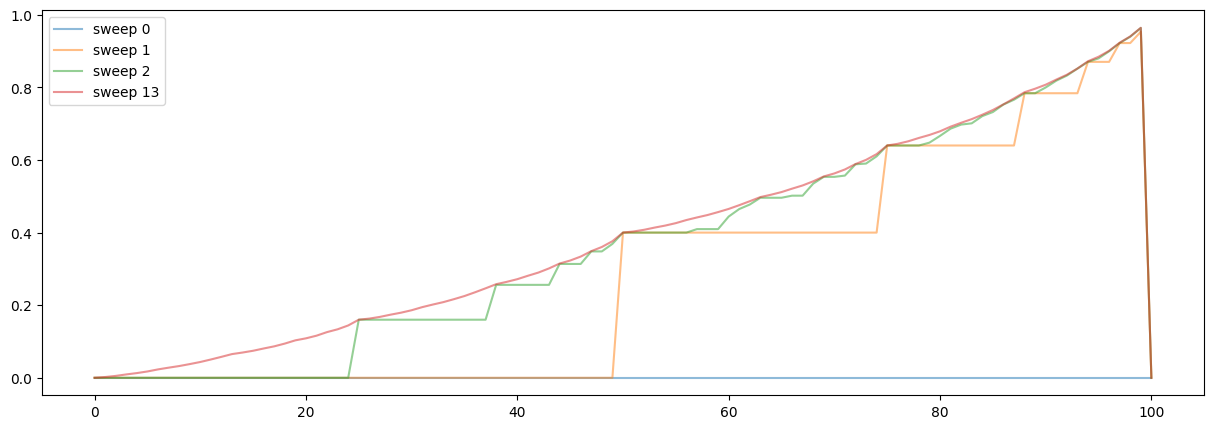

In [217]:
plt.figure(figsize=(15, 5))
for i, hist in enumerate(history):
    if i not in [0,1,2,len(history)-1]:
        continue
    plt.plot(np.arange(101),hist[:],label = f"sweep {i}",alpha=0.5)
    plt.legend()
plt.show()


## Policy Iteration


In [218]:
pi = np.zeros(len(states))

gamma = 1

for s in states[1:]:
    sumation = [
        np.sum(
            [
                probability_matrix[a, s, s_prime]
                * (reward_matrix[a, s_prime] + gamma * history[-1][s_prime])
                for s_prime in [s - a, min(s + a, 100)]
            ]
        )
        for a in range(0, min(s, goal - s)+1)
    ]
    pi[s] = np.argmax(np.round(sumation, 4))

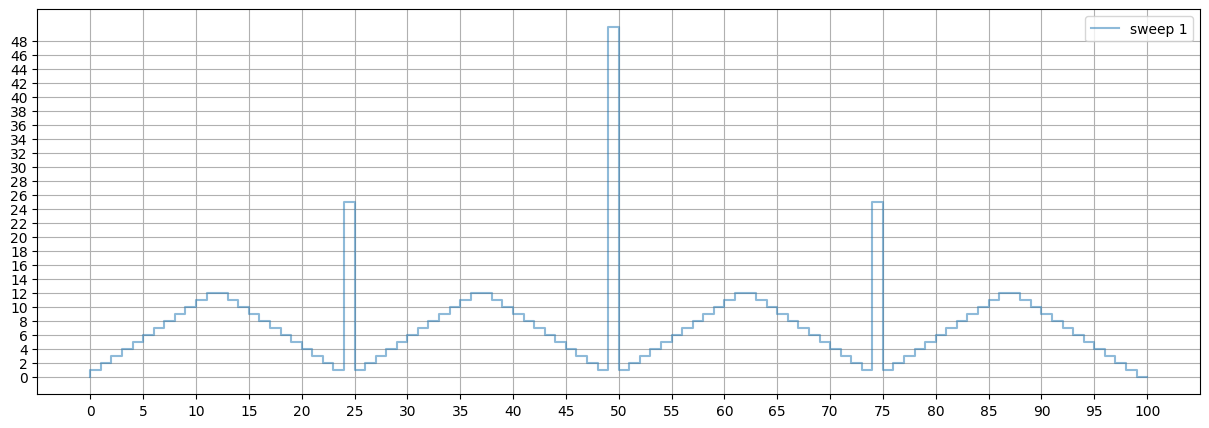

In [235]:
plt.figure(figsize=(15, 5))
plt.step(np.arange(101), pi, label=f"sweep {i}", alpha=0.5)
plt.yticks(np.arange(0, 50, 2))
plt.xticks(np.arange(0, 101, 5))
plt.grid()
plt.legend()

### Answer
The coin is rigged against the player, he can only win 40% of the time, for this matter this policy uses an all in strategy in which he wins or loses. It is curious that 50 and 49 doesn't have a similar action, but the thought behind this might be related to having a second chance, when for instance it surpasses state 50, if for instance it gets to state 60 and bets 10 and loses it can now bet all-in and potentially win and so on and so forth the same can be done on 75 or 87. Until it wins.